In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load the MNIST dataset
(ds_train_full, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

train_size = int(0.8 * ds_info.splits['train'].num_examples)
ds_train = ds_train_full.take(train_size)
ds_val = ds_train_full.skip(train_size)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, (71, 71))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.grayscale_to_rgb(image)
    return image, label

def augment(image, label):
    image, label = preprocess(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [ ]:
batch_size = 32

ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_mnist_DA.keras",
        save_best_only=True,
        monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3)
]

history = model.fit(ds_train, epochs=30, validation_data=ds_val, callbacks=callbacks)

Epoch 1/30
1500/1500 [==============================] - 56s 30ms/step - loss: 1.1364 - accuracy: 0.6229 - val_loss: 0.5772 - val_accuracy: 0.8298
Epoch 2/30
1500/1500 [==============================] - 41s 27ms/step - loss: 0.6950 - accuracy: 0.7694 - val_loss: 0.4336 - val_accuracy: 0.8670
Epoch 3/30
1500/1500 [==============================] - 44s 29ms/step - loss: 0.5914 - accuracy: 0.8046 - val_loss: 0.3683 - val_accuracy: 0.8907
Epoch 4/30
1500/1500 [==============================] - 45s 30ms/step - loss: 0.5306 - accuracy: 0.8237 - val_loss: 0.3245 - val_accuracy: 0.9056
Epoch 5/30
1500/1500 [==============================] - 42s 28ms/step - loss: 0.4942 - accuracy: 0.8357 - val_loss: 0.3130 - val_accuracy: 0.9054
Epoch 6/30
1500/1500 [==============================] - 45s 30ms/step - loss: 0.4644 - accuracy: 0.8458 - val_loss: 0.2953 - val_accuracy: 0.9090
Epoch 7/30
1500/1500 [==============================] - 44s 29ms/step - loss: 0.4450 - accuracy: 0.8536 - val_loss: 0.2834 -

In [ ]:
import keras
test_model = keras.models.load_model('convnet_from_scratch_mnist_DA.keras')
test_loss, test_acc = test_model.evaluate(ds_test)

<Figure size 640x480 with 0 Axes>

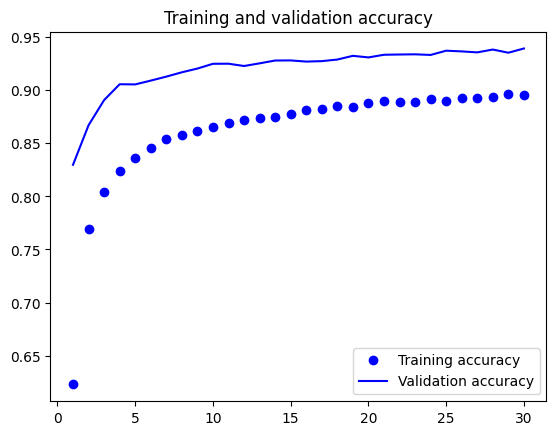

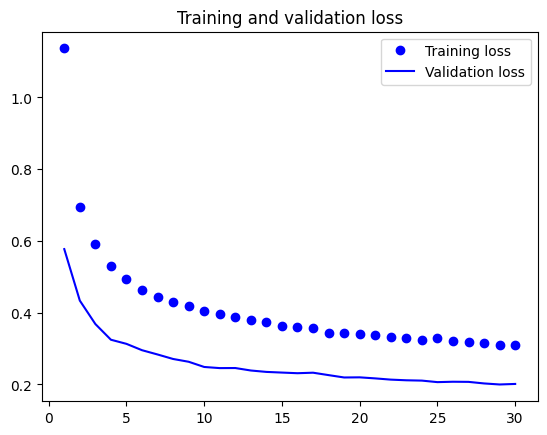

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()